In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [3]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [4]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [5]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

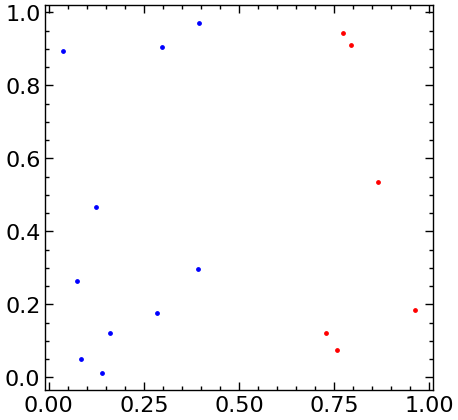

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [7]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [8]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [13]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.0746, 0.3916],
        [0.0746, 0.7289],
        [0.0746, 0.1250],
        [0.0746, 0.1400],
        [0.0746, 0.1607],
        [0.0746, 0.7731],
        [0.0746, 0.0848],
        [0.0746, 0.7578],
        [0.0746, 0.0373],
        [0.0746, 0.9635],
        [0.0746, 0.2971],
        [0.0746, 0.8649],
        [0.0746, 0.3961],
        [0.0746, 0.7957],
        [0.0746, 0.2840],
        [0.3916, 0.7289],
        [0.3916, 0.1250],
        [0.3916, 0.1400],
        [0.3916, 0.1607],
        [0.3916, 0.7731],
        [0.3916, 0.0848],
        [0.3916, 0.7578],
        [0.3916, 0.0373],
        [0.3916, 0.9635],
        [0.3916, 0.2971],
        [0.3916, 0.8649],
        [0.3916, 0.3961],
        [0.3916, 0.7957],
        [0.3916, 0.2840],
        [0.7289, 0.1250],
        [0.7289, 0.1400],
        [0.7289, 0.1607],
        [0.7289, 0.7731],
        [0.7289, 0.0848],
        [0.7289, 0.7578],
        [0.7289, 0.0373],
        [0.7289, 0.9635],
        [0.7289, 0.2971],
        [0.7

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [10]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([-0.0590,  0.0403,  0.6631,  0.2162,  0.6245,  0.2850,  0.6792,  0.0995,
         0.4700,  0.5022,  0.2209,  0.6194,  0.2781,  0.1681,  0.3417,  0.0993,
         0.7221,  0.2752,  0.6835,  0.3440,  0.7382,  0.1585,  0.5291,  0.5612,
         0.2799,  0.6784,  0.3371,  0.2272,  0.4007,  0.6228,  0.1759,  0.5841,
         0.2447,  0.6389,  0.0592,  0.4297,  0.4619,  0.1806,  0.5791,  0.2378,
         0.1278,  0.3014, -0.4469, -0.0387, -0.3781,  0.0161, -0.5636, -0.1931,
        -0.1609, -0.4422, -0.0437, -0.3850, -0.4950, -0.3214,  0.4083,  0.0689,
         0.4630, -0.1167,  0.2539,  0.2860,  0.0047,  0.4032,  0.0619, -0.0480,
         0.1255, -0.3394,  0.0548, -0.5250, -0.1544, -0.1223, -0.4036, -0.0050,
        -0.3464, -0.4563, -0.2828,  0.3942, -0.1855,  0.1850,  0.2172, -0.0641,
         0.3344, -0.0069, -0.1169,  0.0567, -0.5797, -0.2092, -0.1770, -0.4583,
        -0.0598, -0.4011, -0.5111, -0.3375,  0.3705,  0.4027,  0.1214,  0.5199,
         0.1786,  0.0686,  0.2422,  0.03

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [14]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.3188, 0.6695, 0.2086, 0.2592, 0.1667, 0.9753, 0.2142, 0.7086, 0.6329,
        0.8924, 0.6791, 0.8355, 0.7782, 0.9695, 0.2270, 0.3804, 0.3154, 0.3799,
        0.2907, 0.7509, 0.3943, 0.4283, 0.6951, 0.5830, 0.6152, 0.5294, 0.6749,
        0.7352, 0.1623, 0.6952, 0.5989, 0.5682, 0.8239, 0.6480, 0.0544, 1.0379,
        0.2429, 0.8949, 0.4348, 0.9136, 0.7930, 0.4482, 0.4535, 0.3471, 0.8055,
        0.4182, 0.7436, 0.4383, 0.8846, 0.4718, 0.7431, 0.5743, 0.8052, 0.3308,
        0.1100, 1.1263, 0.0664, 0.6210, 0.8886, 0.8412, 0.9062, 0.8932, 0.9932,
        1.1126, 0.2176, 1.0262, 0.1039, 0.5988, 0.7844, 0.8054, 0.7963, 0.8168,
        0.8835, 1.0143, 0.1351, 1.1287, 0.8690, 0.7374, 0.7834, 0.4777, 0.4199,
        0.3781, 0.0396, 0.9108, 0.6735, 0.8471, 0.8890, 0.8815, 0.9185, 0.9737,
        1.1173, 0.2358, 1.0916, 0.2328, 0.9492, 0.4715, 0.9672, 0.8371, 0.4843,
        1.1677, 0.2599, 0.9029, 0.3669, 0.7585, 0.7607, 0.9818, 0.3638, 0.9711,
        0.7465, 0.6796, 0.6782, 0.1196, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [15]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 2,  8],
        [ 4,  5],
        [ 4,  7],
        [ 5,  7],
        [ 6, 14],
        [11, 13]], device='cuda:0')

We will call all the particles in the left column "1" and the right column "2"

In [16]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [17]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [23]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [24]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

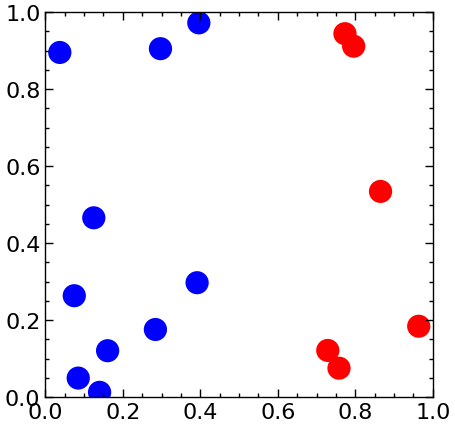

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [29]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [30]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

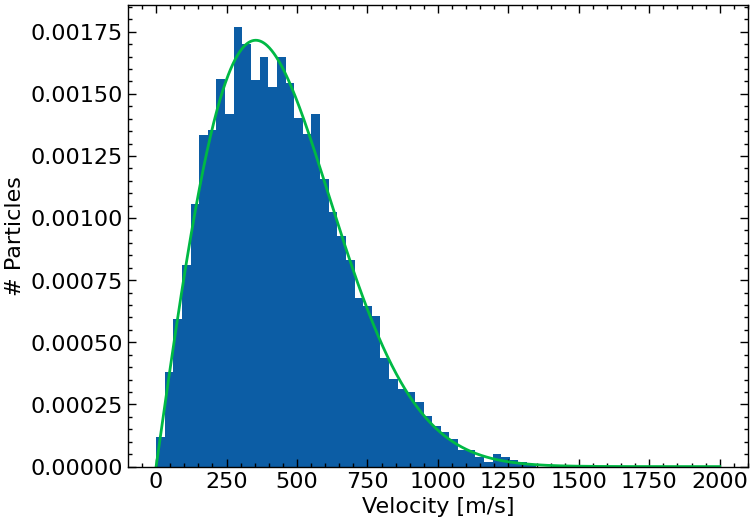

In [31]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)